Le but ici de cette première tache est de créer un "raster plot" qui montre la reproducibilité d'un train de spike avec des répétitions du même stimulus. En particulier, nous allons essayer de répliquer la figure 1 de [Mainen & Sejnowski (1995)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.299.8560&rep=rep1&type=pdf). 


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig_width = 15
phi = (np.sqrt(5)+1)/2
phi = phi**2

# Mainen & Sejnowski, 1995

## contexte
Le but de cette première tache est de créer un "raster plot" qui montre la reproducibilité d'un train de spike avec des répétitions du même stimulus, comme dans ce travail dans la [rétine de rongeurs](https://laurentperrinet.github.io/2019-04-03_a_course_on_vision_and_modelization/#/1/3) ou dans le [cortex (V1) du chat](https://laurentperrinet.github.io/2019-04-03_a_course_on_vision_and_modelization/#/1/6).

Ici, nous allons essayer de répliquer la figure 1 de [Mainen & Sejnowski (1995)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.299.8560&rep=rep1&type=pdf):

![Mainen Sejnowski 1995](http://i.stack.imgur.com/ixnrz.png "figure 1")


QUESTION: écrire un résumé rapide du papier (max 5 lignes) et pourquoi ce résultat est *a priori* surprenant.

Je sais pas

# représentation du temps

In [6]:
dt = .5 # pas de discrétisation du temps
time = np.arange(0, 1000, dt)

In [7]:
time

array([0.000e+00, 5.000e-01, 1.000e+00, ..., 9.985e+02, 9.990e+02,
       9.995e+02])

In [8]:
time.shape

(2000,)

In [9]:
time[:10]

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5])

In [10]:
time[0], time[1], time[-2], time[-1]

(0.0, 0.5, 999.0, 999.5)

Création d'une fonction temporelle (version séquentielle):

In [11]:
start = 0
end = 900
value = 150

def Inp(time=time, start=start, end=end, value=value):
    x=[]
    for t in range(len(time)):
        if start < time[t] < end :
            x.append(value)
        else:
            x.append(0)
    return x

I = Inp(time)

In [12]:
%%timeit
I = Inp(time)

1000 loops, best of 5: 1.55 ms per loop


version vectorisée:

In [13]:
def Inp(time=time, start=start, end=end, value=value):
    I = np.zeros_like(time)
    I[time>start] = value
    I[time>end] = 0
    return I
  
I = Inp(time)

In [14]:
%%timeit
I = Inp(time)

The slowest run took 7.58 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 15.4 µs per loop


QUESTION: essayer de décrire pourquoi le temps de calcul pour créer le vecteur est différent dans les deux versions

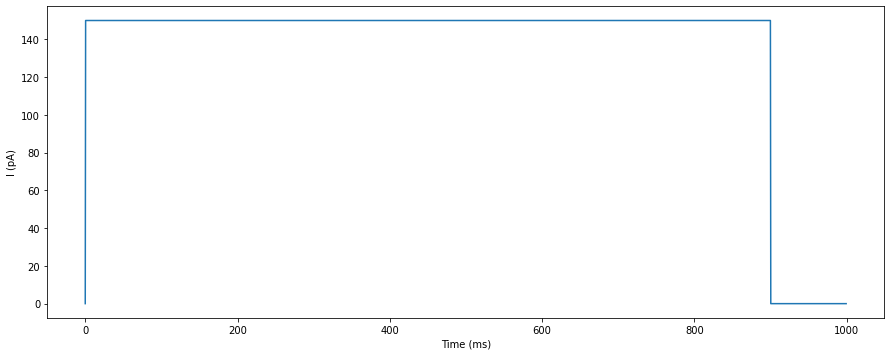

In [15]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width/phi))
ax.plot(time, I)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('I (pA)');

QUESTION: relancer ce calcul en ajustant les paramètres pour correspondre à la figure 1

## un modèle simple de neurone intègre-et-tire `leaky_IF`

Commençons avec cet équation du potentiel membranaire:

$$
\tau \cdot \frac{dV}{dt} = -(V - V_{rest}) + R*I(t)
$$

avec émission d'un "spike" si $V > V_{rest}$, et alors $V= V_{rest}$ pour $3 ms$.


In [16]:
Vthreshold = -53
def leaky_IF(time=time, inp=I, tau=30, v0=-69, R=0.12, 
                Vthreshold=Vthreshold, Vreset=-80, Vspike=30, 
                VRest=-70):
    V = np.ones_like(time)*v0
    dt = time[1]
    for t in range(len(time)-1):
        dV = dt * (-(V[t] - VRest) + R*inp[t])/tau
        V[t+1] = V[t] + dV
        
        if V[t]>Vthreshold:
            V[t+1] = Vspike
        if V[t] == Vspike:
            V[t+1] = Vreset
         
    return V


In [17]:
np.exp(-1)

0.36787944117144233

In [18]:
3+2 == 4

False

QUESTION: régler le paramètre $R$ pour obtenir une dizaine de potentiels d'action - quel est l'interprétation de ce paramètre et quelles est l'unité de mesure?

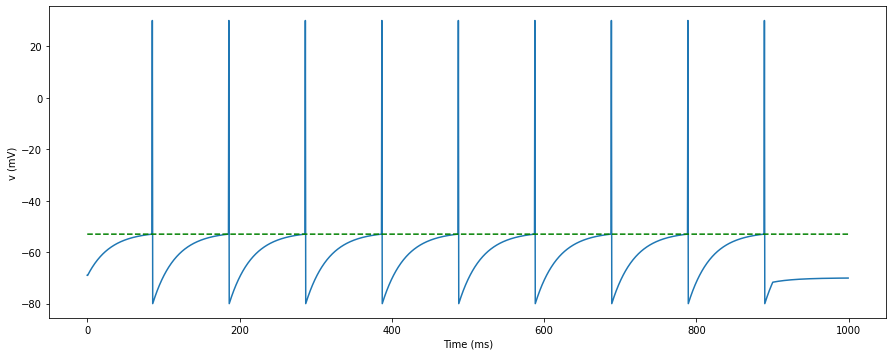

In [19]:
V = leaky_IF(time, I)

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, V)
ax.plot(time, np.ones_like(time)*Vthreshold, 'g--')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v (mV)');

QUESTION: quel est l'effet de $I_0$ sur la fréquence de décharge?

I_0= 125.0


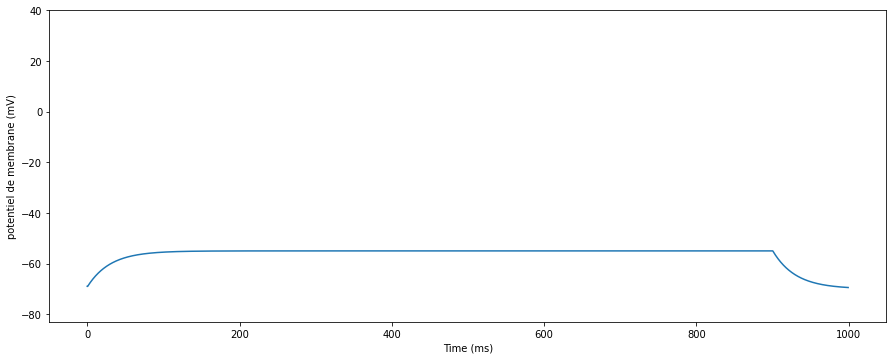

I_0= 168.75


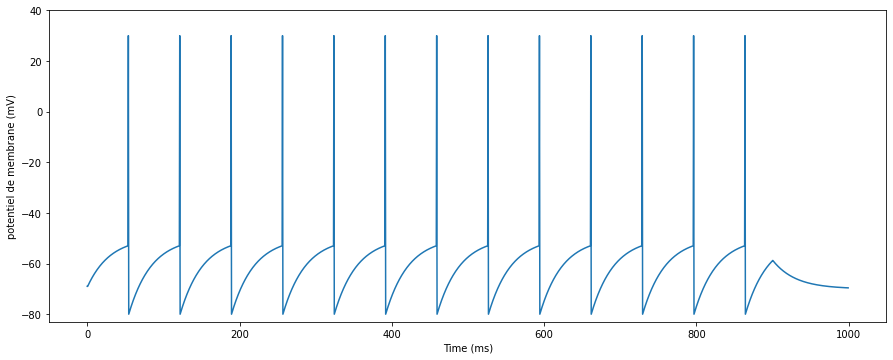

I_0= 212.5


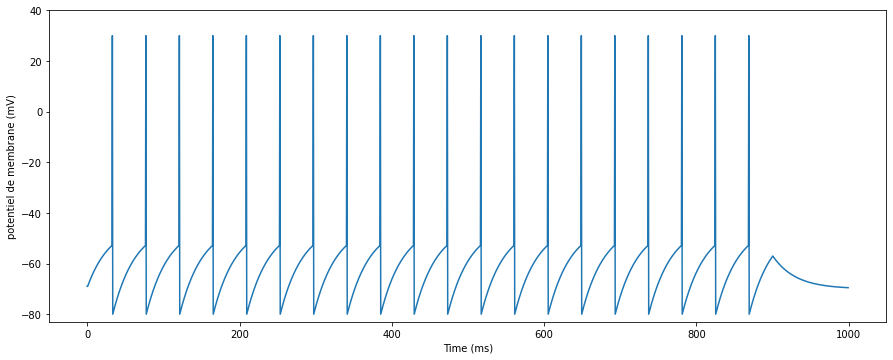

I_0= 256.25


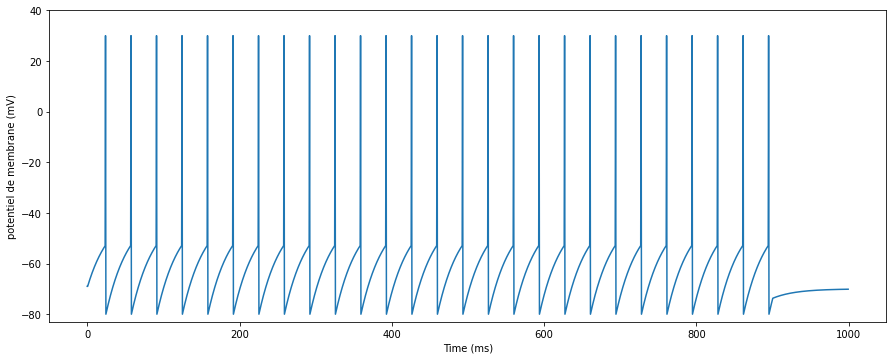

I_0= 300.0


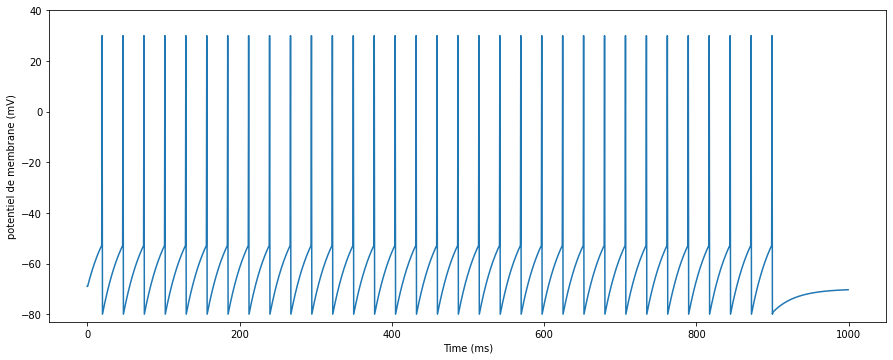

In [20]:
for rho in np.linspace(0.5, 1.2, 5):
    I_0_ = rho*250
    print('I_0=', I_0_)
    V= leaky_IF(time, Inp(value=I_0_))

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.plot(time, V)
    ax.set_ylim(-83, 40)
    ax.set_ylabel("potentiel de membrane (mV)")
    ax.set_xlabel('Time (ms)')
    plt.show()

Plusieurs essais montrent que c'est parfaitement reproductible, contrairement à la figure:

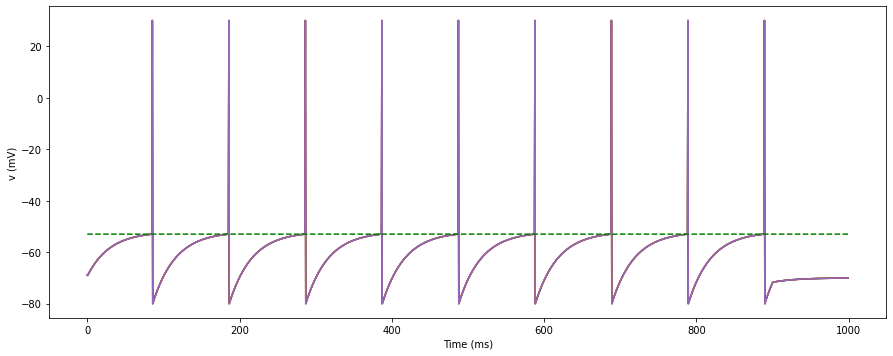

In [21]:
n_trials = 5
V1 = np.zeros((n_trials,len(time)))

for i in range(n_trials):
    V1[i, :] = leaky_IF()

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, V1.T)
ax.plot(time, np.ones_like(time)*Vthreshold, 'g--')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v (mV)');

QUESTION: ce modèle semble ne pas reproduire les résultats, une explication?

## Création d'un input bruité

Un modèle linéaire de diffusion permet de créer simplement un bruit:

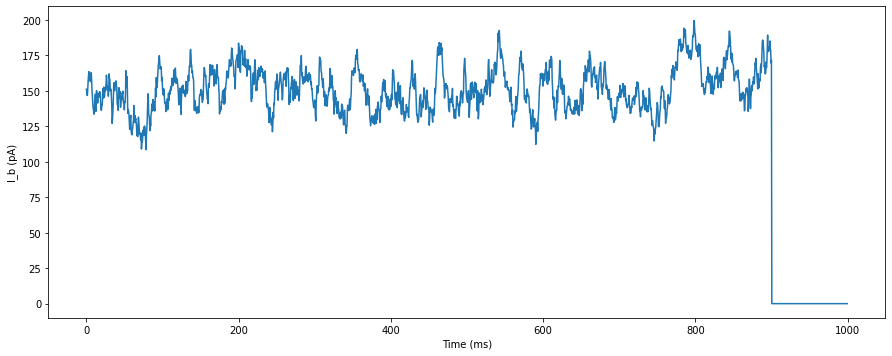

In [22]:
def Bruit(time=time, tau_n=10, I_n=100, I_0=150, start=start, end=end):
    dt = time[1]
    x=np.ones_like(time)
    for t in range(len(x)-1):
        n = np.random.randn()*I_n
        x[t+1] = (1-dt/tau_n)*x[t] + (dt*n/tau_n)
    
    x += I_0
    x[time<start], x[time>end] = 0, 0
    
    return x

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, Bruit())
ax.set_xlabel('Time (ms)')
ax.set_ylabel('I_b (pA)');

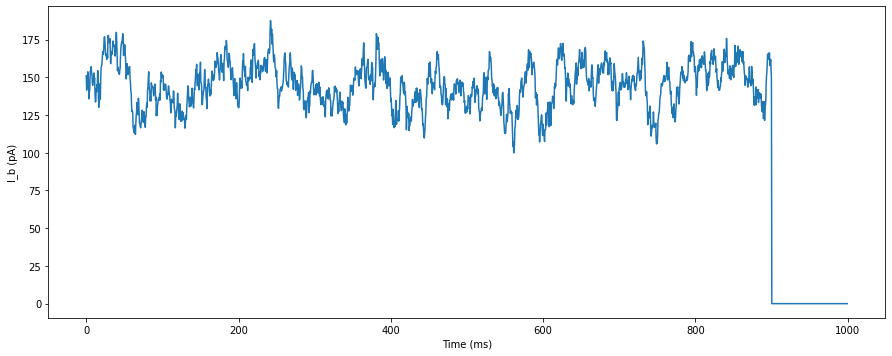

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, Bruit())
ax.set_xlabel('Time (ms)')
ax.set_ylabel('I_b (pA)');

QUESTION: ce modèle représente-t-il bien celui dans le papier? régler $I_n$ et $I_0$ pour obtenir quelque chose qui corresponde mieux.

## Neurone LIF avec Input bruité

Observons maintenant la réponse de notre neurone LIF à cette entrée:

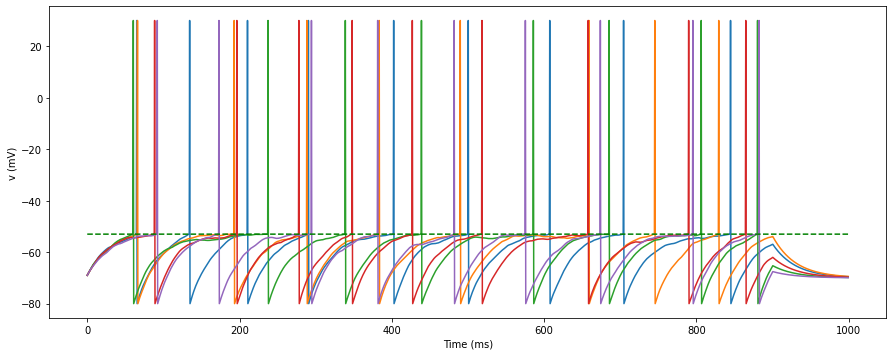

In [24]:
n_trials = 5
V1 = np.zeros((n_trials,len(time)))

for i in range(n_trials):
    V1[i, :] = leaky_IF(time, Bruit())

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, V1.T)
ax.plot(time, np.ones_like(time)*Vthreshold, 'g--')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v (mV)');

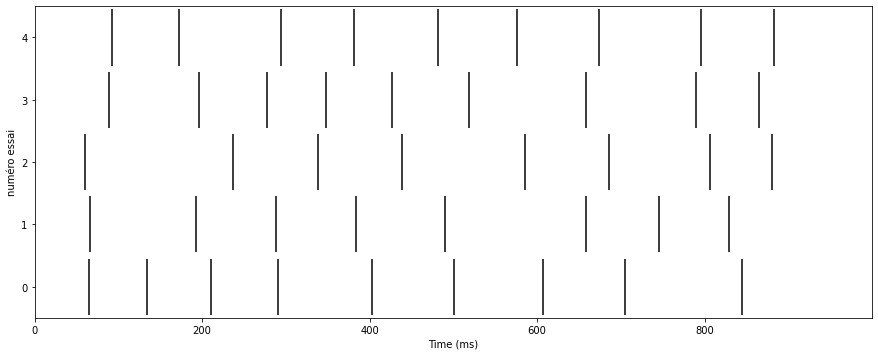

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.eventplot([dt*np.where(V1.T[:, i] == 30)[0] for i in range(0, n_trials)], 
              colors='black', lineoffsets=1, linelengths=0.9);
ax.set_ylabel('numéro essai')
ax.set_xlabel('Time (ms)')
ax.set_xlim(time.min(), time.max())
ax.set_ylim(-.5, n_trials-.5);

QUESTION: régler $I_n$ et $I_0$ pour obtenir quelque chose qui corresponde mieux à la sortie observée:

I_0= 125.0


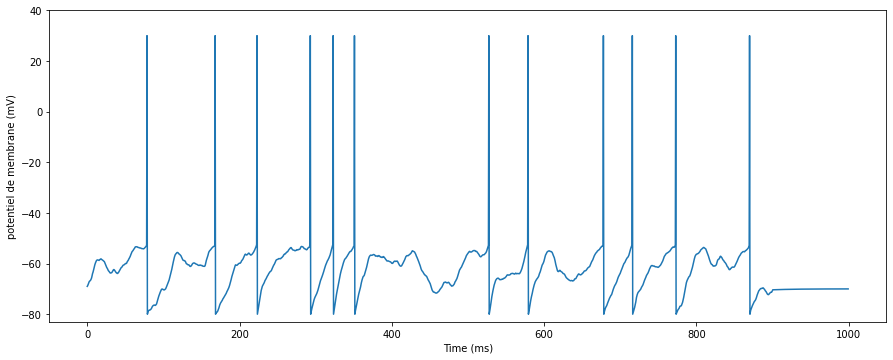

I_0= 168.75


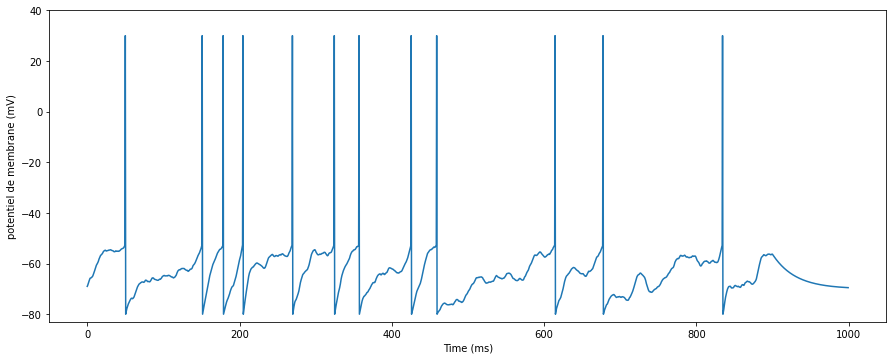

I_0= 212.5


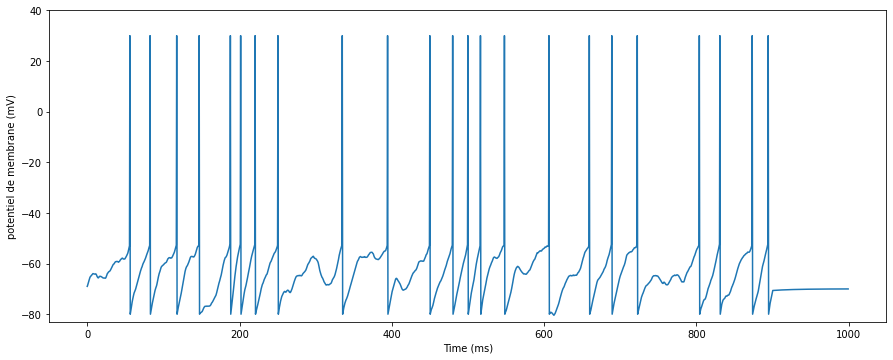

I_0= 256.25


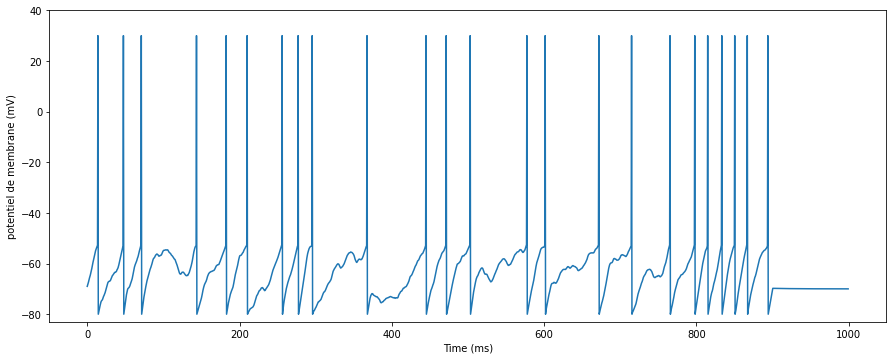

I_0= 300.0


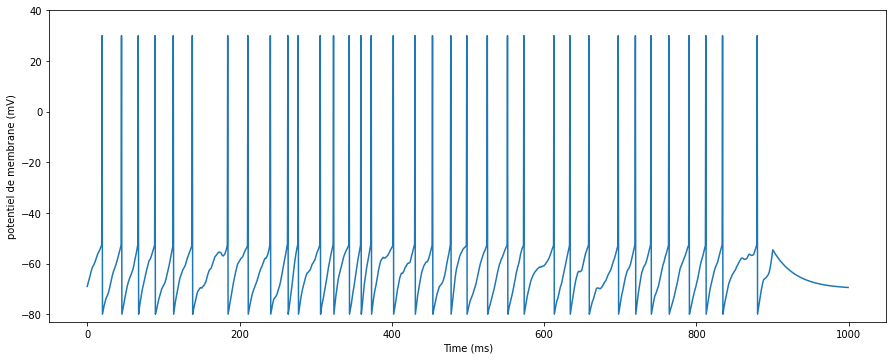

In [26]:
for rho in np.linspace(0.5, 1.2, 5):
    I_0_ = rho*250
    print('I_0=', I_0_)
    V= leaky_IF(time, Bruit(time, I_n=1000, I_0=I_0_))

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.plot(time, V)
    ax.set_ylim(-83, 40)
    ax.set_ylabel("potentiel de membrane (mV)")
    ax.set_xlabel('Time (ms)')
    plt.show()

I_n= 300.0


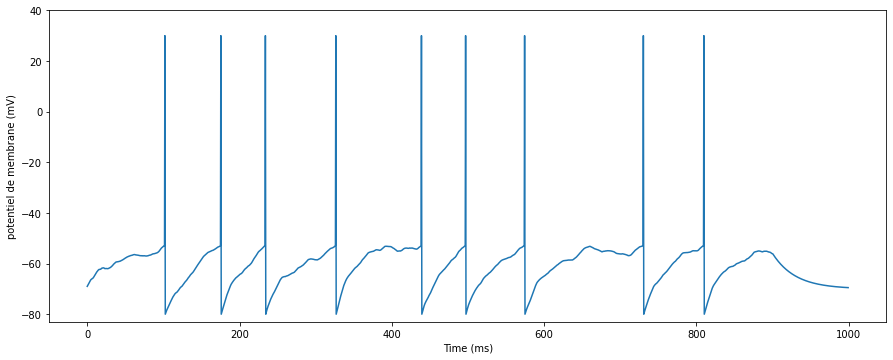

I_n= 399.99999999999994


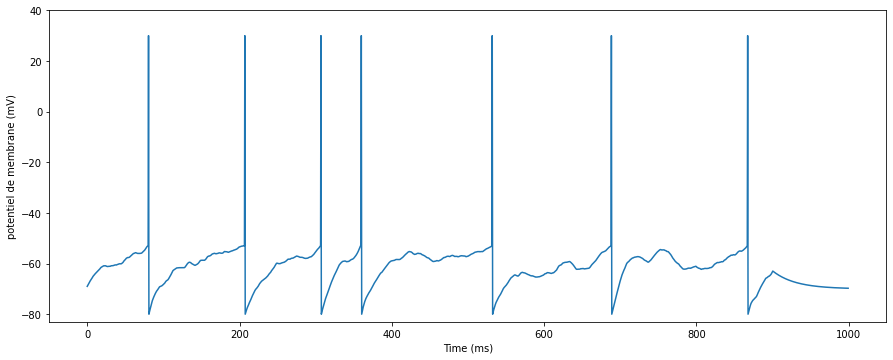

I_n= 500.0


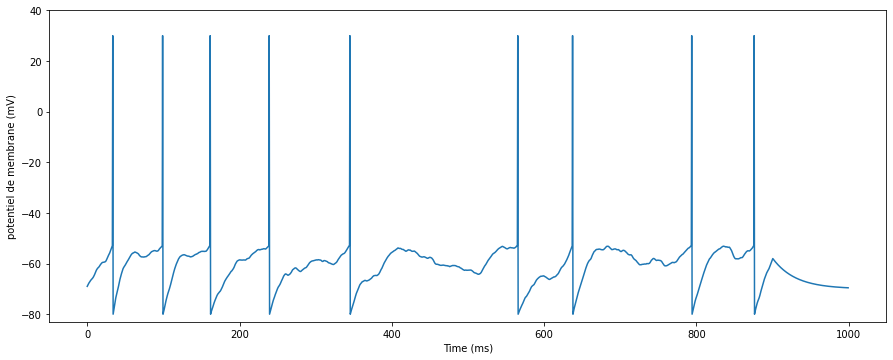

I_n= 600.0


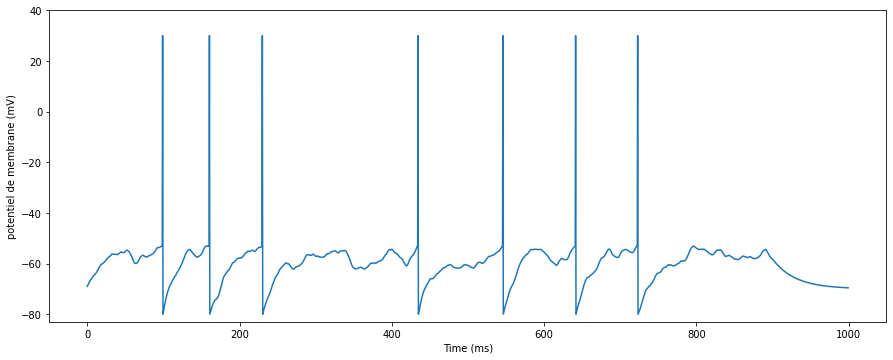

I_n= 700.0


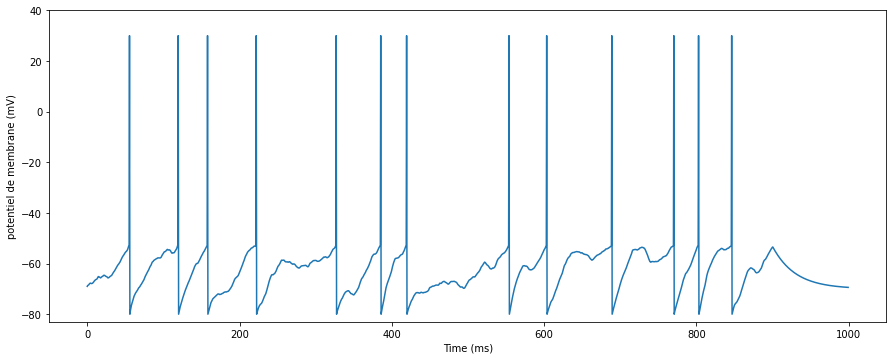

In [27]:
for rho in np.linspace(0.6, 1.4, 5):
    I_n_ = rho*500
    print('I_n=', I_n_)
    V= leaky_IF(time, Bruit(time, I_n=I_n_, I_0=150))

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.plot(time, V)
    ax.set_ylim(-83, 40)
    ax.set_ylabel("potentiel de membrane (mV)")
    ax.set_xlabel('Time (ms)')

    plt.show()

QUESTION: obtient-on bien quelque chose de reproductible?

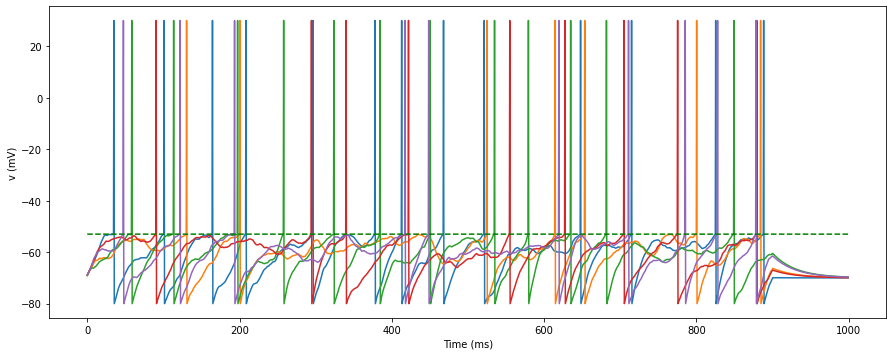

In [28]:
n_trials = 5
V1 = np.zeros((n_trials,len(time)))

for i in range(n_trials):
    V1[i, :] = leaky_IF(time, Bruit(time, I_n=500, I_0=150))

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, V1.T)
ax.plot(time, np.ones_like(time)*Vthreshold, 'g--')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v (mV)');

## Bruit "gelé" ?

QUESTION: quel est la nature du bruit utilisé dans l'article? pourquoi peut-on le décrire comme un [bruit gelé](https://www.oxfordreference.com/view/10.1093/oi/authority.20110803095836900) ?

QUESTION: comment implanter un tel bruit? que savez-vous des générateurs de bruit utilisés dans un ordinateur?

In [29]:
help(np.random.seed)

Help on built-in function seed:

seed(...) method of numpy.random.mtrand.RandomState instance
    seed(self, seed=None)
    
    Reseed a legacy MT19937 BitGenerator
    
    Notes
    -----
    This is a convenience, legacy function.
    
    The best practice is to **not** reseed a BitGenerator, rather to
    recreate a new one. This method is here for legacy reasons.
    This example demonstrates best practice.
    
    >>> from numpy.random import MT19937
    >>> from numpy.random import RandomState, SeedSequence
    >>> rs = RandomState(MT19937(SeedSequence(123456789)))
    # Later, you want to restart the stream
    >>> rs = RandomState(MT19937(SeedSequence(987654321)))



In [30]:
np.random.randn()

0.7159304960343325

In [31]:
np.random.seed(42) # douglas adams
np.random.randn()

0.4967141530112327

In [32]:
np.random.randn()

-0.13826430117118466

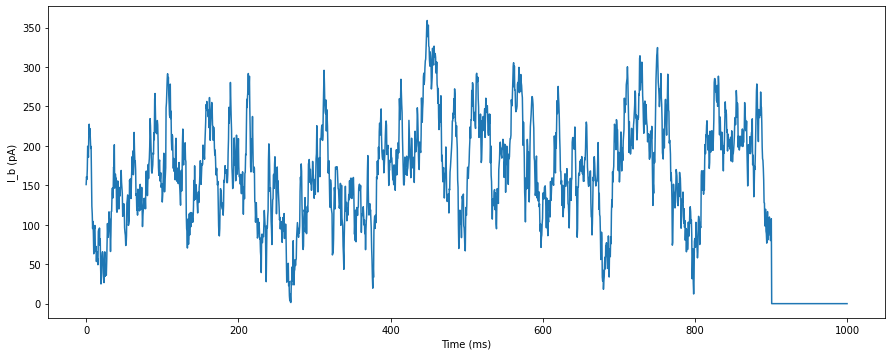

In [33]:
def Bruit(time=time, tau_n=10, I_n=400, I_0=150, seed=42, start=start, end=end):
    np.random.seed(seed)
    dt = time[1]
    x=np.ones_like(time)
    for t in range(len(x)-1):
        n = np.random.randn()*I_n
        x[t+1] = (1-dt/tau_n)*x[t]+ (dt*n/tau_n)
    
    x += I_0
    x[time<start], x[time>end] = 0,0
    
    return x

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, Bruit())
ax.set_xlabel('Time (ms)')
ax.set_ylabel('I_b (pA)');

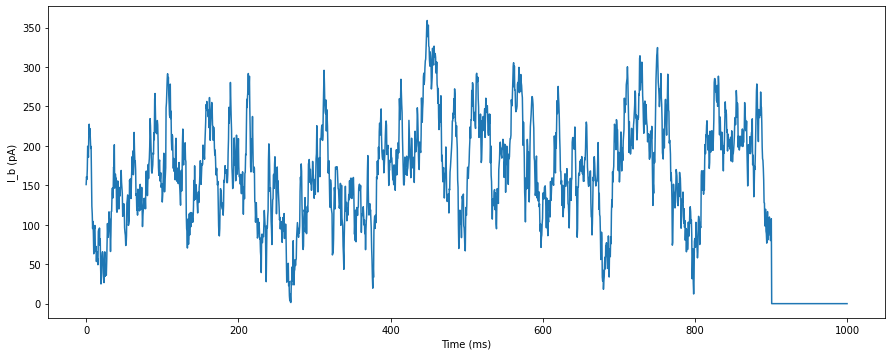

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, Bruit())
ax.set_xlabel('Time (ms)')
ax.set_ylabel('I_b (pA)');

## Plusieurs trials
Ici on montre le maintien du temps des spikes en utilisant un input bruité (bruit gelé)

QUESTION: régler le paramètre $I_0$ et $I_n$ pour obtenir une dizaine de potentiels d'action:

number of spikes per trial : [14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14]


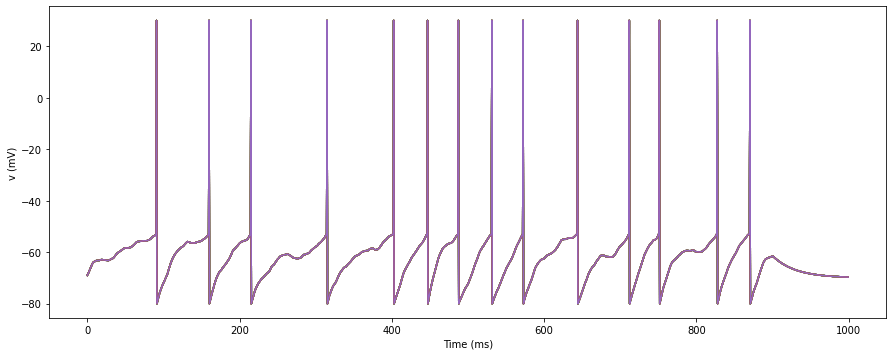

In [35]:
n_trials = 25
V1 = np.zeros((n_trials,len(time)))

for i in range(n_trials):
    V1[i, :] = leaky_IF(time, Bruit(I_n=400, I_0=150))

print('number of spikes per trial :', (V1>0).sum(axis=1))

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, V1.T)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v (mV)');

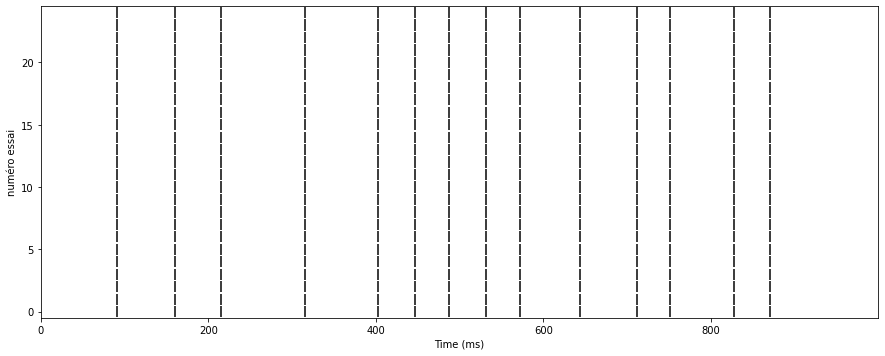

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.eventplot([dt*np.where(V1.T[:, i] == 30)[0] for i in range(0, n_trials)], 
              colors='black', lineoffsets=1, linelengths=0.9);
ax.set_ylabel('numéro essai')
ax.set_xlabel('Time (ms)')
ax.set_xlim(time.min(), time.max())
ax.set_ylim(-.5, n_trials-.5);


On reproduit le paneau B: avec un bruit gelé, les traces des neurones sont reproductibles.

Celà prouve aussi que l'on a "oublié" d'inclure un bruit intrinsèque à la dynamique du neurone:

In [59]:
def leaky_IF(time=time, inp=I, tau=30, v0=-65, R=0.12, 
                Vthreshold =-53, Vreset=-80, Vspike=30, 
                VRest=-70, b=40, seed=None):
    np.random.seed(seed)
    V = np.ones_like(time)*v0
    dt = time[1]
    for t in range(len(time)-1):
        n=np.random.randn()
        dV = dt * (-(V[t] - VRest) + R*(inp[t]+b*n))/tau
        V[t+1] = V[t] + dV
        
        if V[t]>Vthreshold:
            V[t+1]= Vspike
        if V[t] == Vspike:
            V[t+1]=Vreset
         
    return V


Plusieurs essais montrent qu'avec un créneau les temps des spikes perdent leur reproducibilité, comme sur la figure:

QUESTION: régler $I_0$ et $I_n$ pour obtenir un nombre qualitativement similaire de spikes en sortie du neurone. Pour celà, essayer de controler le nombre de spikes :

b = 50.0
number of spikes per trial : [10 10 10 10 10 10  9  9 10 10 10 11  9 10  9 10 10  9  9 10 10  9 10 10
  9]


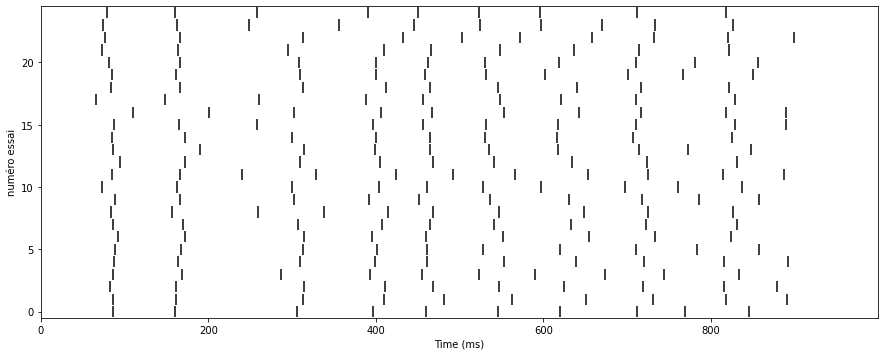

b = 87.5
number of spikes per trial : [10 11 11 10 11 11 10 10 10 10 10 10 11 10 10 11 11 10 12 11 11 10 10 10
 10]


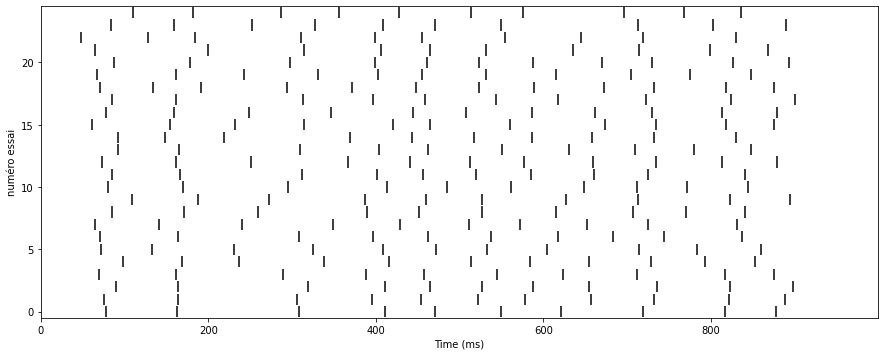

b = 125.0
number of spikes per trial : [11 11 12 10 11 10 11 11 10 11  9 10  9 11 11 11 11  9 10 10 10 10 10 10
 10]


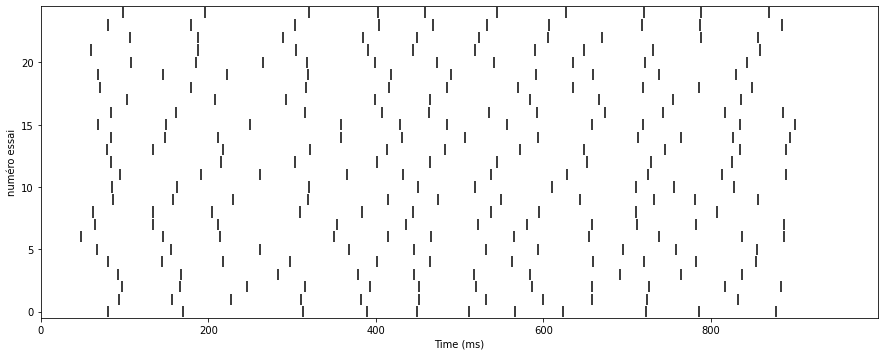

b = 162.5
number of spikes per trial : [11 11 10 12 11 11 12  9 10 13 12 12 10 10 11 11 10 11  9  9 10  9 12 13
 11]


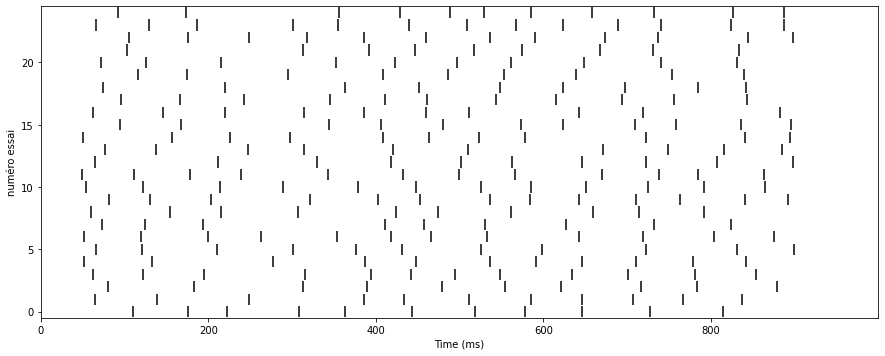

b = 200.0
number of spikes per trial : [11 12 11 13 13 10 11 11 10 11 10 10 12 12 10 12 12 12 10 11 10 10 11 12
 10]


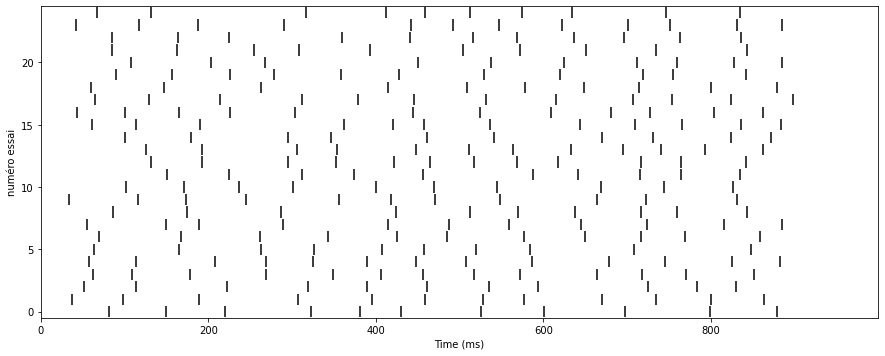

In [61]:
for rho in np.linspace(0.5, 2., 5):
    b_ = rho*100
    print('b =', b_)
    VA = np.zeros((n_trials,len(time)))

    for i in range(n_trials):
        VA[i, :] = leaky_IF(time, Bruit(I_n=100, I_0=150), b=b_)

    print('number of spikes per trial :', (VA>0).sum(axis=1))

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.eventplot([dt*np.where(VA.T[:, i] == 30)[0] for i in range(0, n_trials)], 
                colors='black', lineoffsets=1, linelengths=0.9);
    ax.set_ylabel('numéro essai')
    ax.set_xlabel('Time (ms)')
    ax.set_xlim(time.min(), time.max())
    ax.set_ylim(-.5, n_trials-.5);
    plt.show()

I_n = 140.0
number of spikes per trial : [15 15 15 15 15 15 16 15 15 15 15 15 15 15 15 15 16 15 15 15 15 15 16 15
 15]


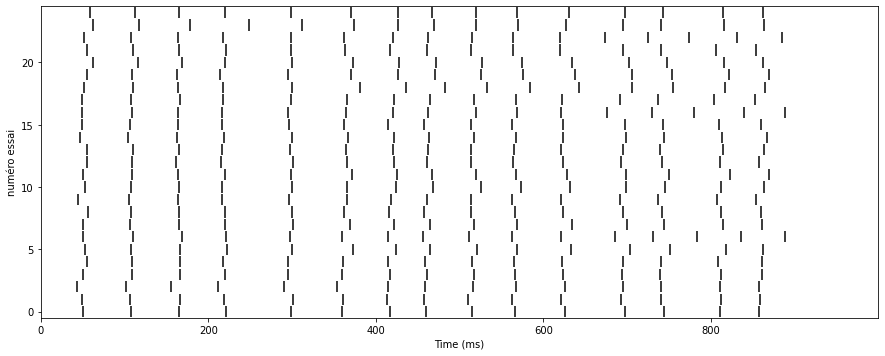

I_n = 170.0
number of spikes per trial : [15 15 15 16 15 15 16 15 15 15 15 15 15 15 16 16 15 15 15 16 15 16 16 16
 15]


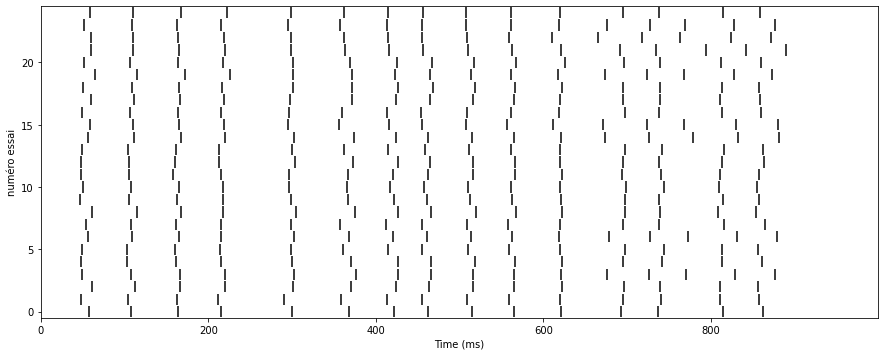

I_n = 200.0
number of spikes per trial : [16 16 15 15 15 15 15 16 16 16 15 16 16 16 16 15 15 16 15 16 16 15 15 16
 15]


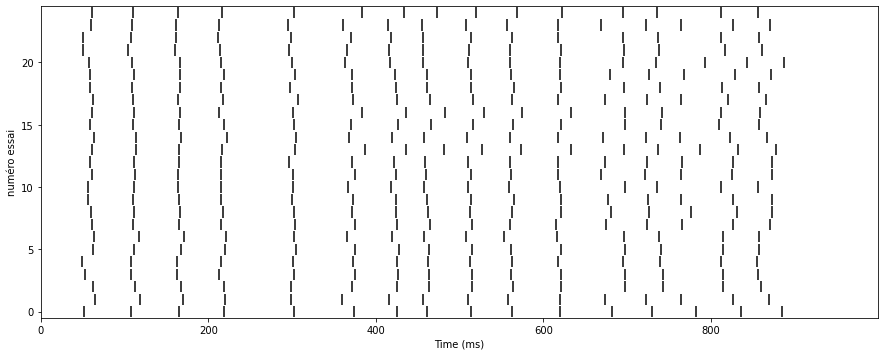

I_n = 229.99999999999997
number of spikes per trial : [16 16 16 16 16 15 16 16 16 15 15 16 16 16 15 16 16 16 16 16 16 15 16 16
 16]


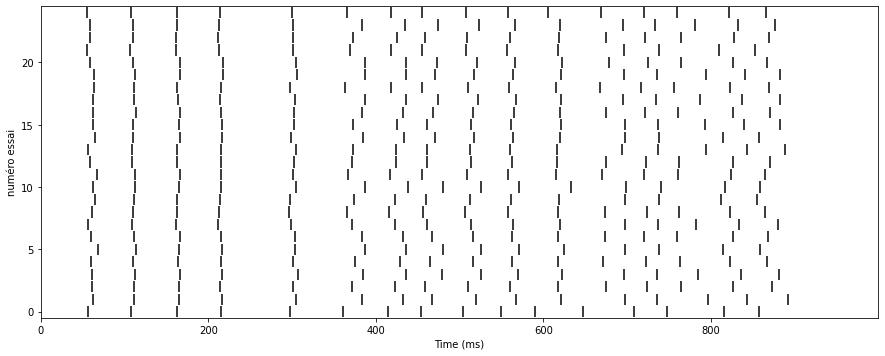

I_n = 260.0
number of spikes per trial : [16 16 16 16 16 16 16 16 16 16 16 16 16 15 16 16 16 15 16 16 16 16 16 16
 16]


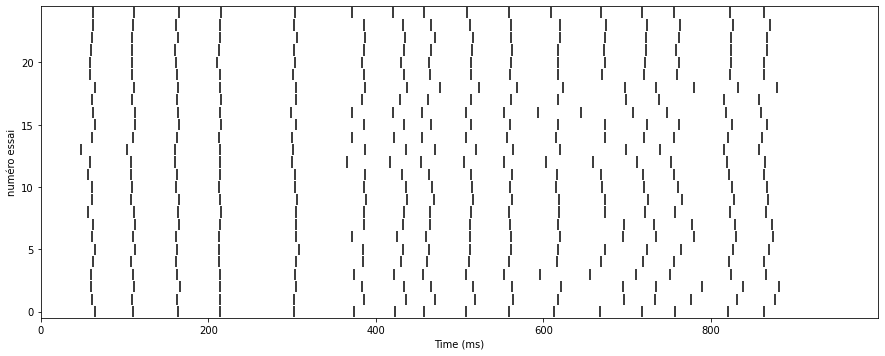

In [62]:
for rho in np.linspace(0.7, 1.3, 5):
    I_n_ = rho*200
    print('I_n =', I_n_)
    VA = np.zeros((n_trials,len(time)))

    for i in range(n_trials):
        VA[i, :] = leaky_IF(time, Bruit(I_n=I_n_, I_0=175))

    print('number of spikes per trial :', (VA>0).sum(axis=1))

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.eventplot([dt*np.where(VA.T[:, i] == 30)[0] for i in range(0, n_trials)], 
                colors='black', lineoffsets=1, linelengths=0.9);
    ax.set_ylabel('numéro essai')
    ax.set_xlabel('Time (ms)')
    ax.set_xlim(time.min(), time.max())
    ax.set_ylim(-.5, n_trials-.5);
    plt.show()

QUESTION: voir l'influence de $I_0$ sur le comportement

rho= 0.7


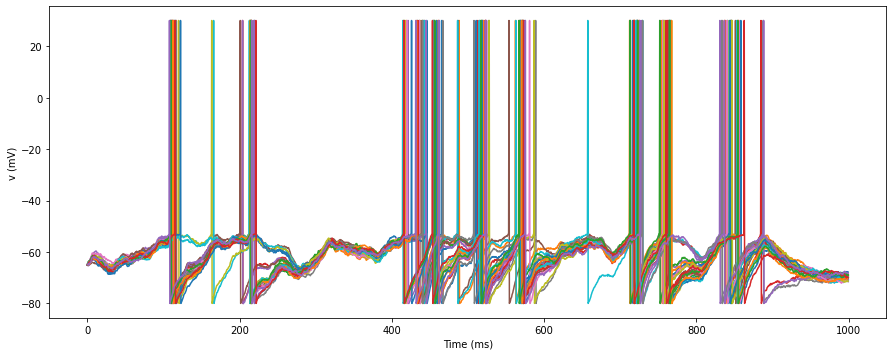

rho= 0.85


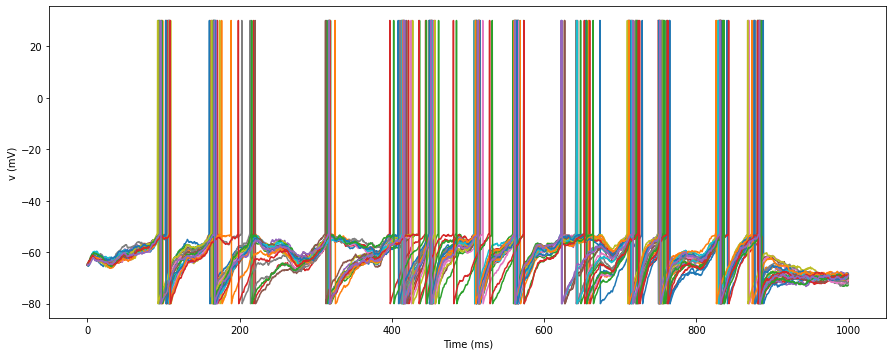

rho= 1.0


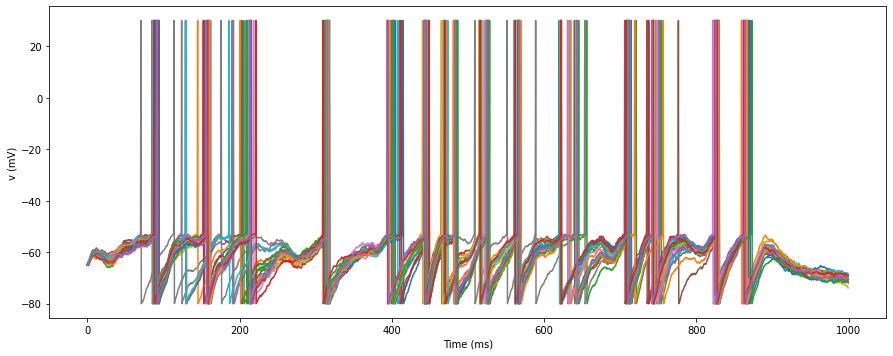

rho= 1.15


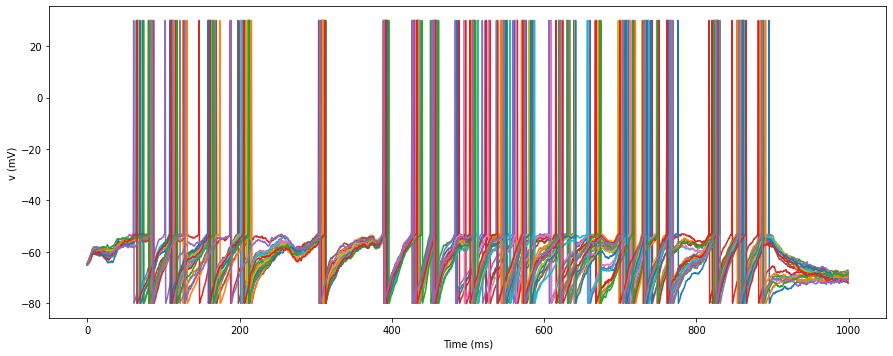

rho= 1.3


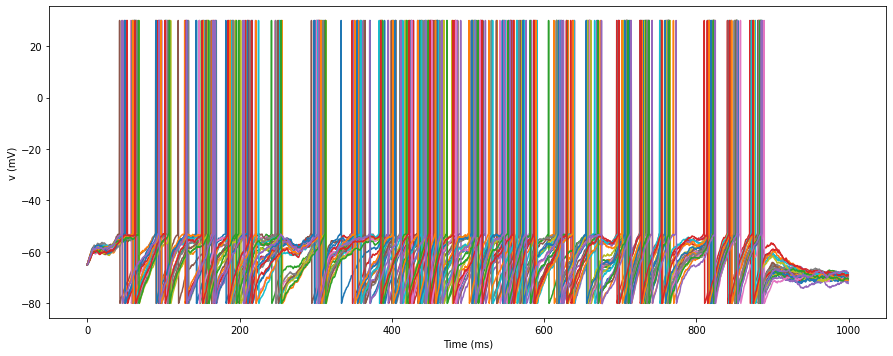

In [39]:
for rho in np.linspace(0.7, 1.3, 5):
    print('rho=', rho)
    VA = np.zeros((n_trials,len(time)))

    for i in range(n_trials):
        VA[i, :] = leaky_IF(time, Bruit(I_n=500, I_0=rho*150))

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.plot(time, VA.T)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('v (mV)');
    plt.show()

QUESTION: voir l'influence de $I_0$ sur le comportement, *quand le bruit est nul* :

I_0_= 135.0
number of spikes per trial : [1 3 1 2 2 1 0 3 1 0 1 1 3 3 2 2 2 1 2 3 3 1 3 2 2]


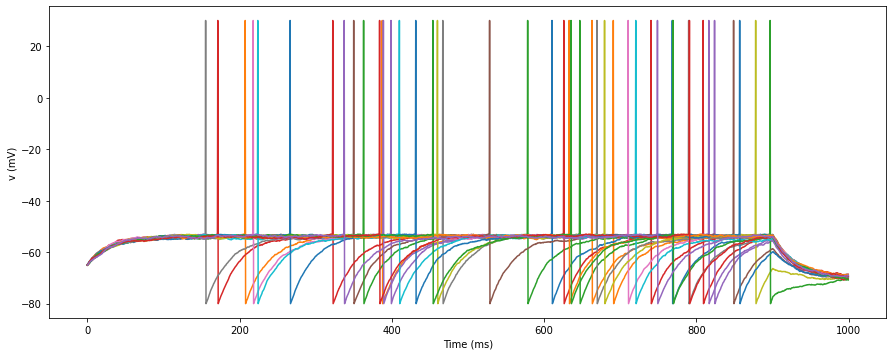

I_0_= 142.5
number of spikes per trial : [5 6 7 5 7 6 7 6 6 6 6 6 7 6 6 5 5 7 5 6 6 7 5 6 7]


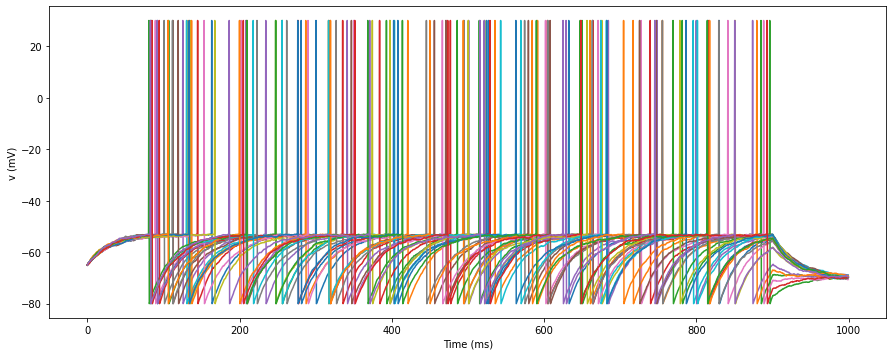

I_0_= 150.0
number of spikes per trial : [ 9 10  9  9  9  9  8  9  9  9  9  9  9  9  9  9  9  8  8  9  9  9  9  8
  9]


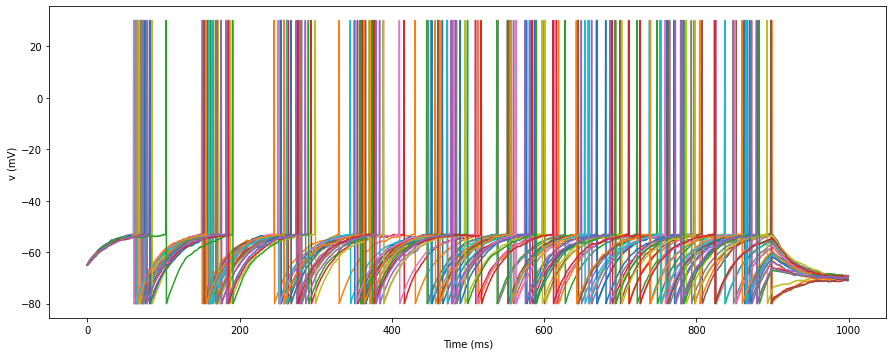

I_0_= 157.5
number of spikes per trial : [11 11 11 11 11 11 11 11 11 11 10 11 11 11 11 11 11 11 11 11 11 11 11 11
 11]


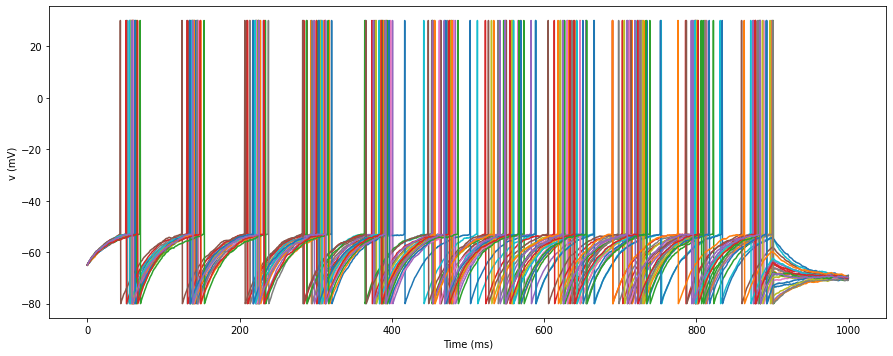

I_0_= 165.0
number of spikes per trial : [12 13 12 12 12 12 12 13 13 12 13 12 12 12 12 12 13 12 12 12 13 13 13 13
 12]


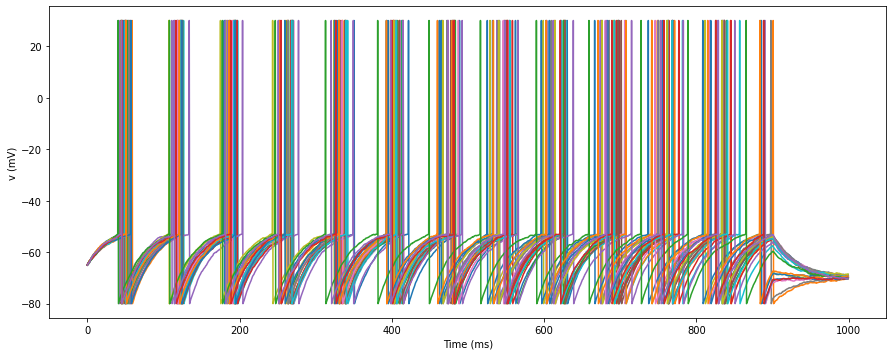

In [64]:
for rho in np.linspace(0.9, 1.1, 5):
    I_0_ = rho*150
    print('I_0_=', I_0_)
    VA = np.zeros((n_trials,len(time)))

    for i in range(n_trials):
        VA[i, :] = leaky_IF(time, Bruit(I_n=0, I_0=I_0_))

    print('number of spikes per trial :', (VA>0).sum(axis=1))
    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.plot(time, VA.T)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('v (mV)');
    plt.show()

QUESTION: reproduire le paneau A: quand le bruit est nul, les traces des neurones ne sont pas reproductibles:

number of spikes per trial : [ 9  8  9  9  9  9  8  9  9  9 10  8  9  8  9  9  9  9  8  9  8  9  9  9
  9]


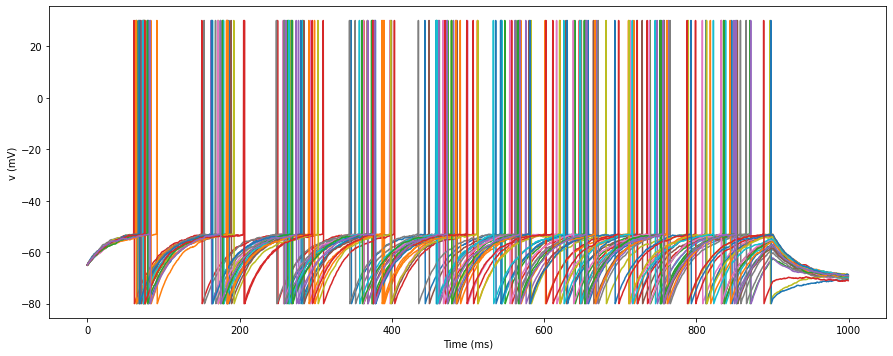

In [65]:
seed = 2020
VA = np.zeros((n_trials,len(time)))
b_A = Bruit(I_n=0, I_0=150, seed=seed)

for i in range(n_trials):
    VA[i, :] = leaky_IF(time, b_A)


print('number of spikes per trial :', (VA>0).sum(axis=1))

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, VA.T)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v (mV)');

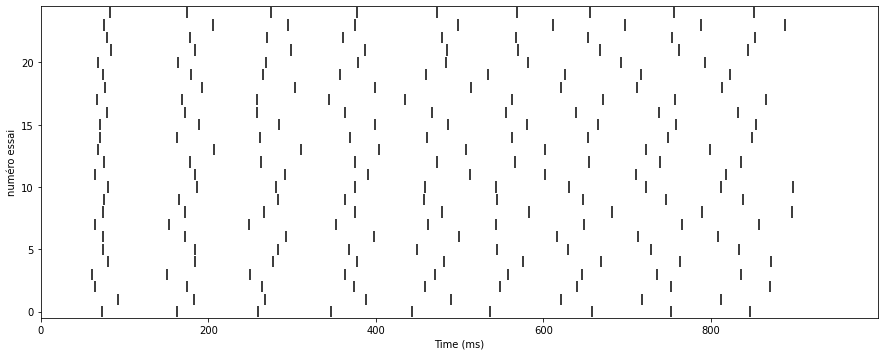

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.eventplot([dt*np.where(VA.T[:, i] == 30)[0] for i in range(0, n_trials)], 
              colors='black', lineoffsets=1, linelengths=0.9);
ax.set_ylabel('numéro essai')
ax.set_xlabel('Time (ms)')
ax.set_xlim(time.min(), time.max())
ax.set_ylim(-.5, n_trials-.5);

QUESTION: reproduire le paneau B: avec un bruit gelé, les traces des neurones sont reproductibles, même quand le neurone possède un bruit intrinsèque:

number of spikes per trial : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


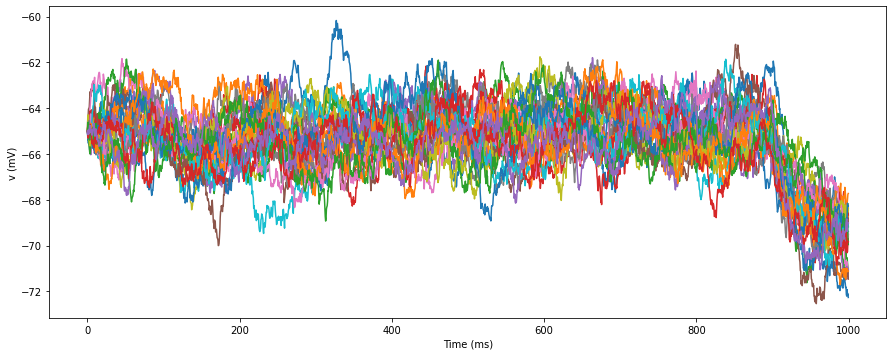

In [43]:
VB = np.zeros((n_trials, len(time)))
b_B = Bruit(I_n=42, I_0=42, seed=seed)
for i in range(n_trials):
    VB[i, :] = leaky_IF(time, b_B)

print('number of spikes per trial :', (VB>0).sum(axis=1))

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, VB.T)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v (mV)');

Pour résumer:

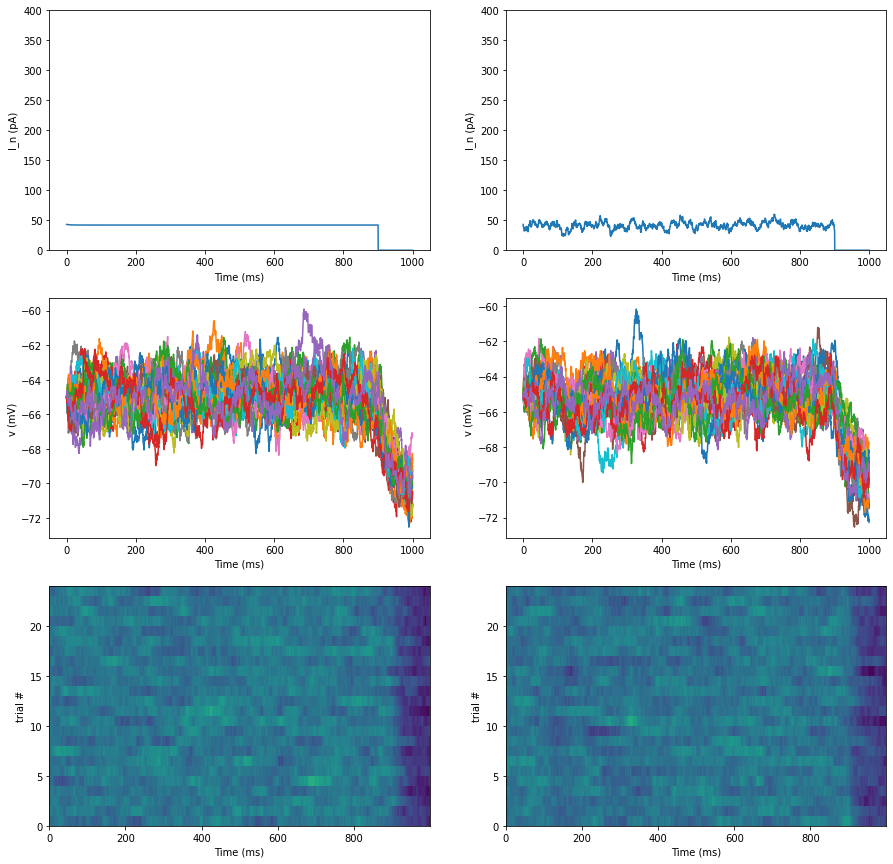

In [44]:
fig, axs = plt.subplots(3, 2, figsize=(fig_width, fig_width))

axs[0][0].plot(time, b_A)
axs[0][1].plot(time, b_B)
axs[1][0].plot(time, VA.T)
axs[1][1].plot(time, VB.T)
axs[2][0].pcolor(time, range(n_trials), VA, vmax=Vthreshold)
axs[2][1].pcolor(time, range(n_trials), VB, vmax=Vthreshold)
for ax in axs.ravel(): 
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('v (mV)');
axs[2][0].set_ylabel('trial #');
axs[2][1].set_ylabel('trial #');
for i in range(2):
    axs[0][i].set_ylabel('I_n (pA)')
    axs[0][i].set_ylim(0, 400);

QUESTION: conclure rapidement: à quel point a-t-on expliqué le phénomène? quelle est la conclusion sur la préférence des neurones à des signaux dynamiques?